In [10]:
# This script was written using Python 3.7

import pandas as pd # written using v. 0.24.2
import numpy as np # written using v. 1.16.2
import math # written using v. 1.1.0
import matplotlib.pyplot as plt # written using v. 3.1.1
import scipy.stats as ss # written using v. 1.3.2
import cmocean # written using v. 2.0

## Script summary
This script builds a model to predict N2 fixation (NFR) based on data collected from the Mid-/South Atlantic Bight in Aug, 2016, as follows:

1) The full training/test/validation dataset is imported and parred down appropriately (measurements made under manipulated environmental conditions eg incubated with excessive C are removed; superfluous explanatory variables eg station number, pressure, etc. are removed; nans are removed). Finally, in order to reduce over-weighting the importance of extreme values in training, the target data were log-transformed as in Sammartino et al (2018, Remote Sensing). Where n2 fixation was not detected, the log of the median detection limit was used.

2) 20% of the full dataset is randomly selected and witheld for model validation later (leaving 80% for training and testing).

3) Explanatory variables are scaled based on the training/testing data.

4) Hyperparameter sensitivity analysis is performed; the model is tuned.

5) Model performance is assessed using the validation dataset.

6) Predictive X data (CTD data) are read in and scaled.

7) Predictive X data are used to predict NFR; predicted NFR are saved for later use.

## 1) The full training/test/validation dataset is imported and parred down appropriately

- measurements made under manipulated environmental conditions eg incubated with excessive C are removed
- superfluous explanatory variables eg station number, pressure, etc. are removed
- nans are removed

In [11]:
# import file with NFR and corresponding hydrographic information
# see Sharp16_15N2tracer_allrates_hydrograph_ReadMe.csv for full file description

infile = '..\Calculations\Sharp16_15N2tracer_allrates_hydrograph.csv' # This file contains all replicate rate measurements
df = pd.read_csv(infile)

# NFR_flag = flag for rate measurements (both FC and NFR)
#      - 0 = NFR value can be trusted
#      - 1 = analytical error occurred (e.g., 15N2 was not sufficiently enriched, PN on t=f filter was too low or high 
#            (outside linear range), autosampler/reduction column issues, etc.
#      - 2 = N2 fixation was below analytical detection limit

# If NFR_flag = 1, NFR and FC = -9999
# If NFR_flag = 2, NFR and FC = 0

# IrregInc_flag = Irregular incubation flag
#     - 0 = incubation is normal
#     - 1 = incubation conditions were manipulated (e.g., incubation was artificially dark, C was added,, or inc was 12 
#           instead of 24 hours)

print(df.shape)
df.columns

(379, 34)


Index(['UniqID', 'LocID', 'Sta', 'Depth_m', 'IrregInc_flag', 'IncLength_h',
       'IncVol_L', 'GlucoseAdd_ul', 'PCconc_uM', 'PCconc_err', 'PNconc_uM',
       'PNconc_err', 'FC_d', 'FC_LOD', 'NFR_nmolNLd', 'NFR_LOD', 'NFR_flag',
       'SeaFloor_Depth_m', 'Lat', 'Lon', 'Press_db', 'Sigmat_kgm3', 'Temp_C',
       'Sal', 'DO_umolkg', 'Fluor_mgm3', 'PO4_uM', 'PO4_err', 'NO2_uM',
       'NO2_err', 'NO3_uM', 'NO3_err', 'NH4_nM', 'NH4_err'],
      dtype='object')

In [12]:
# exclude rows where the incubation conditions were manipulated (i.e., did not represent the environment) and where
# the rate could not be calculated due to an analytical error
df = df[(df.IrregInc_flag == 0) & (df.NFR_flag !=1)]
print(df.shape)

(252, 34)


In [13]:
# select explanatory data for the model
# here, we use all available parameters deemed likely to be important

X = df.drop(['UniqID', 'LocID', 'IncVol_L', 'Sta', 'IrregInc_flag', 'IncLength_h', 'GlucoseAdd_ul', 'PNconc_uM', 'PNconc_err', 'FC_d',
             'FC_LOD', 'NFR_LOD', 'NFR_flag', 'PO4_err', 'NO2_uM', 'NO2_err', 'NO3_err', 'NH4_nM', 'NH4_err', 'PCconc_err',
             'Press_db','Sigmat_kgm3','PO4_uM','NO3_uM','Lat','Lon','PCconc_uM','DO_umolkg'], axis = 1).dropna()
y = X.NFR_nmolNLd
X = X.drop(['NFR_nmolNLd'],axis = 1)

print(np.shape(X))
print(np.shape(y))

X.head()

(252, 5)
(252,)


,Depth_m,SeaFloor_Depth_m,Temp_C,Sal,Fluor_mgm3
0,0.93,-1260,26.766684,33.831280,0.588138
1,0.93,-1260,26.766684,33.831280,0.588138
2,0.93,-1260,26.766684,33.831280,0.588138
3,35.37,-1260,15.049992,35.069827,2.362376
4,35.37,-1260,15.049992,35.069827,2.362376


In [14]:
# target data are log-transformed
logy = []
for i in y:
    if i == 0:
        logyi = np.log10(np.median(df.NFR_LOD)) # if Nfix was not detectable, use median LOD instead of value
    else:
        logyi = np.log10(i)
    logy.append('%f' % logyi)

y = logy

In [15]:
# target data are converted back to pd df
y = pd.DataFrame(y, columns = ['nfr'])
type(y)

pandas.core.frame.DataFrame

## 2) 20% of the full dataset is randomly selected and witheld for model validation later 
(leaving 80% for training and testing)

In [16]:
from sklearn.model_selection import train_test_split # v. 0.22.1

# split dataset in training/test and validation data (80:20)
X_tt, X_val,y_tt,y_val = train_test_split(X,y,test_size = 0.2) # this split function is random

# shape of train/test and val objects
print(X_tt.shape)
print(X_val.shape)

# # reformat y_val to match y_pred later
y_val = np.array(y_val, dtype = float).reshape(len(y_val),)

print(y_val.shape)

(201, 5)
(51, 5)
(51,)


## 3) Explanatory variables are scaled based on the training/testing data

In [17]:
from sklearn.preprocessing import StandardScaler # v. 0.22.1

# scale all X data based on training dataset
scaler = StandardScaler()
scaler.fit(X_tt)

X_tt = scaler.transform(X_tt)
X_val = scaler.transform(X_val)

## 4) Hyperparameter sensitivity analysis is performed; the model is tuned

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# create model object
model = RandomForestRegressor()

# define type of cross validation to be used
cv = KFold(n_splits = 9, shuffle = True)

# set-up hyperparameter grid
treecount = np.arange(1,51,2) # number of decisions trees in the ensemble
maxdepth = np.arange(1,21,2) # longest path between root node and final node

param_grid = {'n_estimators':treecount, 'max_depth':maxdepth}

# define scoring parameters to evaluate the predictions on the test set
scoring = 'r2'

# create GridSearchCV object
grid_cv = GridSearchCV(model, param_grid, scoring = scoring, cv = cv, refit = True) # when refit = True, will refit the best
# estimator with the entire dataset

# fit model to the train/test data
grid_cv.fit(X_tt,np.ravel(y_tt, order = 'C'))

mean_test_score = grid_cv.cv_results_['mean_test_score']
std_test_score = grid_cv.cv_results_['std_test_score']
best_std_test_score = grid_cv.cv_results_['std_test_score'][mean_test_score ==  grid_cv.best_score_]

print("Tuned Parameter(s): {}".format(grid_cv.best_params_))
print("Best score is: %f +/- %f" % (grid_cv.best_score_,best_std_test_score)) # mean cross-validated score of the best estimator

Tuned Parameter(s): {'max_depth': 15, 'n_estimators': 35}
Best score is: 0.813753 +/- 0.128691


## 5) Model performance is assessed using validation dataset

VALIDATION DATASET (black line), r2:  0.904289, rmse:  0.274642, p value:  0.000000


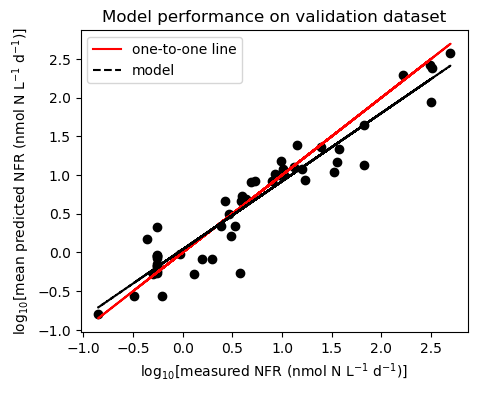

In [19]:
# predict y for validation data subset
y_pred = grid_cv.predict(X_val)

# plot predicted validation y against true validation y
fig, (ax) =  plt.subplots(1, 1, figsize = (5, 4), dpi = 100)

plt.plot(y_val,y_pred,'ko')
plt.plot(y_val,y_val, color = 'r', label = "one-to-one line")

plt.xlabel('log$_{10}$[measured NFR (nmol N L$^{-1}$ d$^{-1}$)]')
plt.ylabel('log$_{10}$[mean predicted NFR (nmol N L$^{-1}$ d$^{-1}$)]')

# perform and plot linear regression of true y against predicted y
slope, intercept, r_value, p_value, std_err = ss.linregress(y_val,y_pred)
line = slope*y_val + intercept
plt.plot(y_val,line, "k--", label = "model")

# calculate r2 and rmse using sklearn calculation method (differs slightly from ss method)
r2_comp = metrics.r2_score(y_val,y_pred)
rmse_comp = np.sqrt(metrics.mean_squared_error(y_val,y_pred))

ax.legend()
plt.title("Model performance on validation dataset")

print("VALIDATION DATASET (black line), r2:  %f, rmse:  %f, p value:  %f" % (r2_comp,rmse_comp,p_value))

##  6) Predictive data are read in and scaled

In [30]:
# read in compiled, binned satellite data

infile = "../Calculations/Sharp16_BinnedCTDData_bySta.csv"
ctd = pd.read_csv(infile)
ctd = ctd.dropna()
ctd = ctd.sort_values(by = ['Sta','Depth_m'])
ctd.columns

Index(['Sta', 'Depth_m', 'Lat', 'Lon', 'Sal', 'Temp_C', 'Chl_mgm3',
       'DO_umolkg', 'Sigmat_kgm3', 'SeafloorDepth_m'],
      dtype='object')

In [31]:
# # reorganize df to match model training data
# X_ctd = pd.DataFrame(data = {'z': ctd.Depth_m, 'sfz': ctd.SeafloorDepth_m, 'temp': ctd.Temp_C, 'sal': ctd.Sal, 'do': ctd.DO_umolkg, 'chl': ctd.Chl_mgm3})
X_ctd = pd.DataFrame(data = {'z': ctd.Depth_m, 'sfz': ctd.SeafloorDepth_m, 'temp': ctd.Temp_C, 'sal': ctd.Sal, 'chl': ctd.Chl_mgm3})

In [32]:
# scale satellite X data
X_ctd = scaler.transform(X_ctd)

## 7) y is predicted; data are saved for later use

In [33]:
# predict y for predictive X data
y_pred = grid_cv.predict(X_ctd)

In [34]:
# save predictor variables and predicted nfr to a csv file
# OutputData = pd.DataFrame(data = {'Sta': ctd.Sta, 'Depth_m': ctd.Depth_m, 'SeafloorDepth_m': ctd.SeafloorDepth_m, 'Temp_C': ctd.Temp_C, 'Sal': ctd.Sal, 'DO_umolkg': ctd.DO_umolkg, 'Chl_mgm3': ctd.Chl_mgm3, 'NFR_log10nmolNLd': y_pred})
OutputData = pd.DataFrame(data = {'Lat': ctd.Lat, 'Lon': ctd.Lon, 'Sta': ctd.Sta, 'Depth_m': ctd.Depth_m, 'SeafloorDepth_m': ctd.SeafloorDepth_m, 'Temp_C': ctd.Temp_C, 'Sal': ctd.Sal, 'Chl_mgm3': ctd.Chl_mgm3, 'NFR_log10nmolNLd': y_pred})
OutputData.to_csv('../Calculations/RF_CTDPred.csv')

## SUPPLEMENTAL:  Quick visualization of predicted data

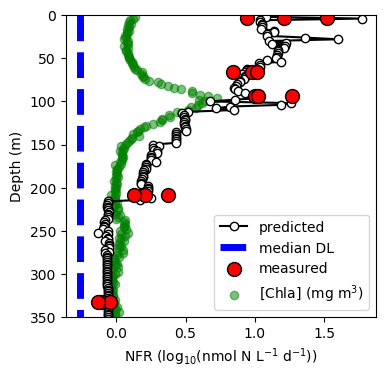

In [89]:
infile = '../Calculations/RF_CTDPred.csv'
pred = pd.read_csv(infile)

a = 20 # station

# log transform measured rates for the given station
nfr_true = df.NFR_nmolNLd[df.Sta == a]
logy = []
for i in nfr_true:
    if i == 0:
        logyi = np.log10(np.median(df.NFR_LOD)) # if Nfix was not detectable, use median LOD instead of value
    else:
        logyi = np.log10(i)
    logy.append('%f' % logyi)
nfr_true = pd.DataFrame(logy, columns = ['nfr'], dtype = float)

# plot
fig, ax = plt.subplots(1,1, dpi = 100, figsize = (4,4))

plt.plot(pred.NFR_log10nmolNLd[pred.Sta == a], pred.Depth_m[pred.Sta == a], '-ok', label = 'predicted', zorder = 0, mfc = 'w')
plt.scatter(nfr_true, df.Depth_m[df.Sta == a], c = 'r', label = 'measured', s = 100, edgecolor = 'k')
plt.plot(np.ones(50,)*np.log10(np.median(df.NFR_LOD)),np.arange(0,500,10), 'b', linewidth = 5, linestyle = '--', label = 'median DL', zorder = -1)

plt.scatter(ctd.Chl_mgm3[ctd.Sta == a] - 0.4,ctd.Depth_m[ctd.Sta == a], color = 'g', zorder = -1, label = '[Chla] (mg m$^{3}$)', alpha = 0.5)

plt.xlabel('NFR (log$_{10}$(nmol N L$^{-1}$ d$^{-1}$))')
plt.ylabel('Depth (m)')
# plt.xlim(-1,3)
plt.ylim(0,350) # MOST MEASUREMENTS ABOVE 150; very few measurements made below 250 m

plt.gca().invert_yaxis()
plt.legend(loc = 'best')
